In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score
from kerastuner.tuners import RandomSearch


/var/folders/mq/f0db6b294kj_3n5gcz2cyqlh0000gn/T/ipykernel_17587/3019158042.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# Load the data which already has been cleaned, filled the missing values, spread the value with bigger frequency, taken the lagged values
df=pd.read_excel('exchange_rates.xlsx')
df.dropna(inplace=True)
df.head()

,date,usd_cad,usd_eur,usd_gbp,polrate_ca,polrate_eu,polrate_uk,polrate_us_lower,polrate_us_upper,cpi_ca_lag1m,...,usd_gbp_lag20d,usd_cad_lag21d,usd_eur_lag21d,usd_gbp_lag21d,usd_cad_lag22d,usd_eur_lag22d,usd_gbp_lag22d,usd_cad_lag23d,usd_eur_lag23d,usd_gbp_lag23d
0,2018-04-02,0.774114,1.2288,1.4032,1.25,0.0,0.5,1.5,1.75,103.209448,...,1.3856,0.776277,1.2314,1.3769,0.778816,1.2216,1.3755,0.780884,1.2211,1.3794
1,2018-04-03,0.781250,1.2261,1.4068,1.25,0.0,0.5,1.5,1.75,103.209448,...,1.3886,0.770297,1.2330,1.3856,0.776277,1.2314,1.3769,0.778816,1.2216,1.3755
2,2018-04-04,0.781189,1.2292,1.4076,1.25,0.0,0.5,1.5,1.75,103.209448,...,1.3888,0.775675,1.2415,1.3886,0.770297,1.2330,1.3856,0.776277,1.2314,1.3769
3,2018-04-05,0.782656,1.2230,1.3991,1.25,0.0,0.5,1.5,1.75,103.209448,...,1.3824,0.769645,1.2397,1.3888,0.775675,1.2415,1.3886,0.770297,1.2330,1.3856
4,2018-04-06,0.783515,1.2274,1.4088,1.25,0.0,0.5,1.5,1.75,103.209448,...,1.3863,0.773036,1.2314,1.3824,0.769645,1.2397,1.3888,0.775675,1.2415,1.3886


In [3]:
#format date column as datetime
df['date'] = pd.to_datetime(df['date'])
#set date as index
df.set_index('date', inplace=True)
df.head()


,usd_cad,usd_eur,usd_gbp,polrate_ca,polrate_eu,polrate_uk,polrate_us_lower,polrate_us_upper,cpi_ca_lag1m,cpi_eu_lag1m,...,usd_gbp_lag20d,usd_cad_lag21d,usd_eur_lag21d,usd_gbp_lag21d,usd_cad_lag22d,usd_eur_lag22d,usd_gbp_lag22d,usd_cad_lag23d,usd_eur_lag23d,usd_gbp_lag23d
date,,,,,,,,,,,,,,,,,,,,,
2018-04-02,0.774114,1.2288,1.4032,1.25,0.0,0.5,1.5,1.75,103.209448,101.94,...,1.3856,0.776277,1.2314,1.3769,0.778816,1.2216,1.3755,0.780884,1.2211,1.3794
2018-04-03,0.781250,1.2261,1.4068,1.25,0.0,0.5,1.5,1.75,103.209448,101.94,...,1.3886,0.770297,1.2330,1.3856,0.776277,1.2314,1.3769,0.778816,1.2216,1.3755
2018-04-04,0.781189,1.2292,1.4076,1.25,0.0,0.5,1.5,1.75,103.209448,101.94,...,1.3888,0.775675,1.2415,1.3886,0.770297,1.2330,1.3856,0.776277,1.2314,1.3769
2018-04-05,0.782656,1.2230,1.3991,1.25,0.0,0.5,1.5,1.75,103.209448,101.94,...,1.3824,0.769645,1.2397,1.3888,0.775675,1.2415,1.3886,0.770297,1.2330,1.3856
2018-04-06,0.783515,1.2274,1.4088,1.25,0.0,0.5,1.5,1.75,103.209448,101.94,...,1.3863,0.773036,1.2314,1.3824,0.769645,1.2397,1.3888,0.775675,1.2415,1.3886


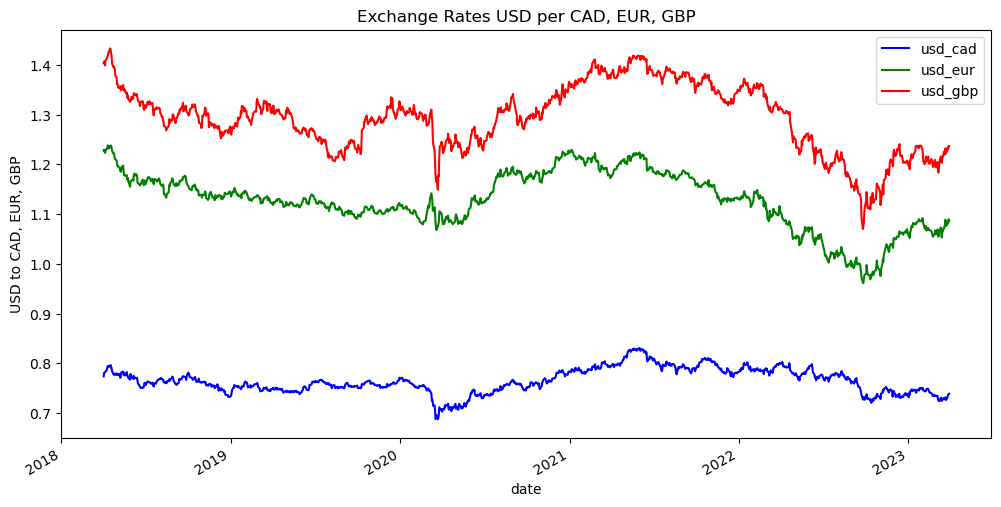

In [72]:
# Create the plot of the exchange rates
fig, ax = plt.subplots(figsize=(12, 6))

df[['usd_cad', 'usd_eur', 'usd_gbp']].plot(ax=ax, color=['blue', 'green', 'red'])
ax.set_ylabel('USD to CAD, EUR, GBP')
ax.set_xlabel('date')
ax.set_title('Exchange Rates USD per CAD, EUR, GBP')

plt.show()

# Descriptive Statistic

In [5]:
from scipy.stats import skew, kurtosis
# Calculate the mean, standard deviation, minimum, and maximum for each currency
means = df.iloc[:, 0:3].mean()
std_dev = df.iloc[:, 0:3].std()
min_values = df.iloc[:, 0:3].min()
max_values = df.iloc[:, 0:3].max()
skewness = df.iloc[:, 0:3].apply(skew)
kurt = df.iloc[:, 0:3].apply(kurtosis)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Mean': means,
    'Standard Deviation': std_dev,
    'Minimum': min_values,
    'Maximum': max_values,
    'Skewness': skewness,
    'Kurtosis': kurt
})

print(summary_df)

             Mean  Standard Deviation   Minimum   Maximum  Skewness  Kurtosis
usd_cad  0.765193            0.025135  0.687805  0.831186  0.052061 -0.056533
usd_eur  1.127909            0.057725  0.961600  1.238400 -0.515935 -0.064165
usd_gbp  1.293042            0.067342  1.070300  1.433200 -0.329925 -0.228753


# Train/Test Split

In [6]:
# Split the data into train and test with the spliting point at 2022-01-01
train= df.loc[df.index<'2022-01-01']
test= df.loc[df.index>='2022-01-01']

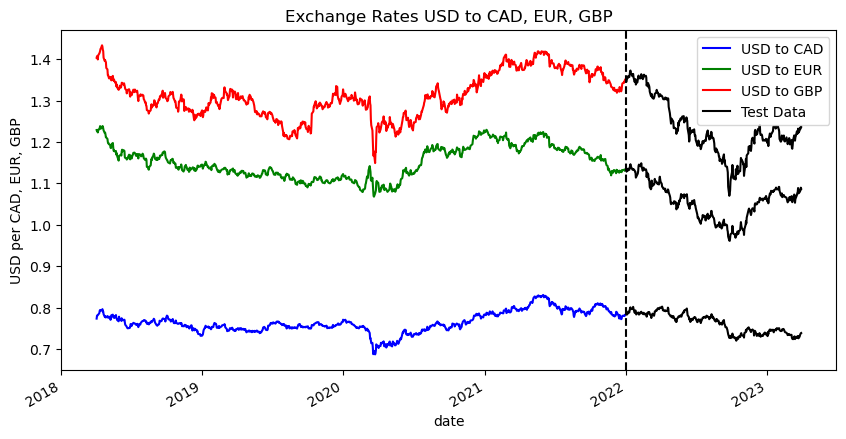

In [7]:
# Spliting plot
fig, ax = plt.subplots(figsize=(10, 5))

train[['usd_cad', 'usd_eur', 'usd_gbp']].plot(ax=ax, color=['blue', 'green', 'red'])
test[['usd_cad', 'usd_eur', 'usd_gbp']].plot(ax=ax, color='black')
ax.set_ylabel('USD per CAD, EUR, GBP')
ax.set_xlabel('date')
ax.set_title('Exchange Rates USD to CAD, EUR, GBP')
ax.axvline(x='2022-01-01', color='black', linestyle='--')
ax.legend(['USD to CAD', 'USD to EUR', 'USD to GBP', 'Test Data'])


plt.show()

In [8]:
column_names_list = list(df.columns)
print(column_names_list)

['usd_cad', 'usd_eur', 'usd_gbp', 'polrate_ca', 'polrate_eu', 'polrate_uk', 'polrate_us_lower', 'polrate_us_upper', 'cpi_ca_lag1m', 'cpi_eu_lag1m', 'cpi_uk_lag1m', 'cpi_us_lag1m', 'm1_ca_lag1m', 'm1_eu_lag1m', 'm1_uk_lag1m', 'm1_us_lag1m', 'm2_ca_lag1m', 'm2_eu_lag1m', 'm2_uk_lag1m', 'm2_us_lag1m', 'uncertainty_ca_lag1m', 'uncertainty_eu_lag1m', 'uncertainty_uk_lag1m', 'uncertainty_us_lag1m', 'unrate_ca_lag1m', 'unrate_eu_lag1m', 'unrate_uk_lag1m', 'unrate_us_lag1m', 'cpi_ca_lag2m', 'cpi_eu_lag2m', 'cpi_uk_lag2m', 'cpi_us_lag2m', 'm1_ca_lag2m', 'm1_eu_lag2m', 'm1_uk_lag2m', 'm1_us_lag2m', 'm2_ca_lag2m', 'm2_eu_lag2m', 'm2_uk_lag2m', 'm2_us_lag2m', 'uncertainty_ca_lag2m', 'uncertainty_eu_lag2m', 'uncertainty_uk_lag2m', 'uncertainty_us_lag2m', 'unrate_ca_lag2m', 'unrate_eu_lag2m', 'unrate_uk_lag2m', 'unrate_us_lag2m', 'cpi_ca_lag3m', 'cpi_eu_lag3m', 'cpi_uk_lag3m', 'cpi_us_lag3m', 'm1_ca_lag3m', 'm1_eu_lag3m', 'm1_uk_lag3m', 'm1_us_lag3m', 'm2_ca_lag3m', 'm2_eu_lag3m', 'm2_uk_lag3m', 'm2

In [9]:
#create the feature and target datasets

FEATURES = df.iloc[:, 3:df.shape[1]].columns.to_numpy() # all regressor columns (except the target column)
TARGET = df.iloc[:, 0:3].columns.to_numpy() 

X_train = train[FEATURES] 

# seperate the target variables each of exchange rates has their own target variable for the model
y_train_cad = train[TARGET[0]]  # usd_cad
y_train_eur = train[TARGET[1]]  # usd_eur
y_train_gbp = train[TARGET[2]]  # usd_gbp

# Testing dataset
X_test = test[FEATURES]

y_test_cad = test[TARGET[0]]  
y_test_eur = test[TARGET[1]] 
y_test_gbp = test[TARGET[2]] 




# Baseline Models

In [47]:
# Initialize the predictions for CAD exchange rate
predicted_prices_cad = []

# Predict the first day's price using the last day's price from training data
predicted_prices_cad.append(y_train_cad.iloc[-1])

# Predict the remaining days' prices using the testing data
for i in range(1, len(y_test_cad)):
    predicted_prices_cad.append(y_test_cad.iloc[i - 1])

# Predictions for EUR exchange rate
predicted_prices_eur = []
predicted_prices_eur.append(y_train_eur.iloc[-1])
for i in range(1, len(y_test_eur)):
    predicted_prices_eur.append(y_test_eur.iloc[i - 1])

# Predictions for GBP exchange rate
predicted_prices_gbp = []
predicted_prices_gbp.append(y_train_gbp.iloc[-1])
for i in range(1, len(y_test_gbp)):
    predicted_prices_gbp.append(y_test_gbp.iloc[i - 1])

test['pre_cadbm'], test['pre_eurbm'], test['pre_gbpbm'] = predicted_prices_cad, predicted_prices_eur, predicted_prices_gbp
df = df.merge(test[['pre_cadbm', 'pre_eurbm', 'pre_gbpbm']], how='left', left_index=True, right_index=True)

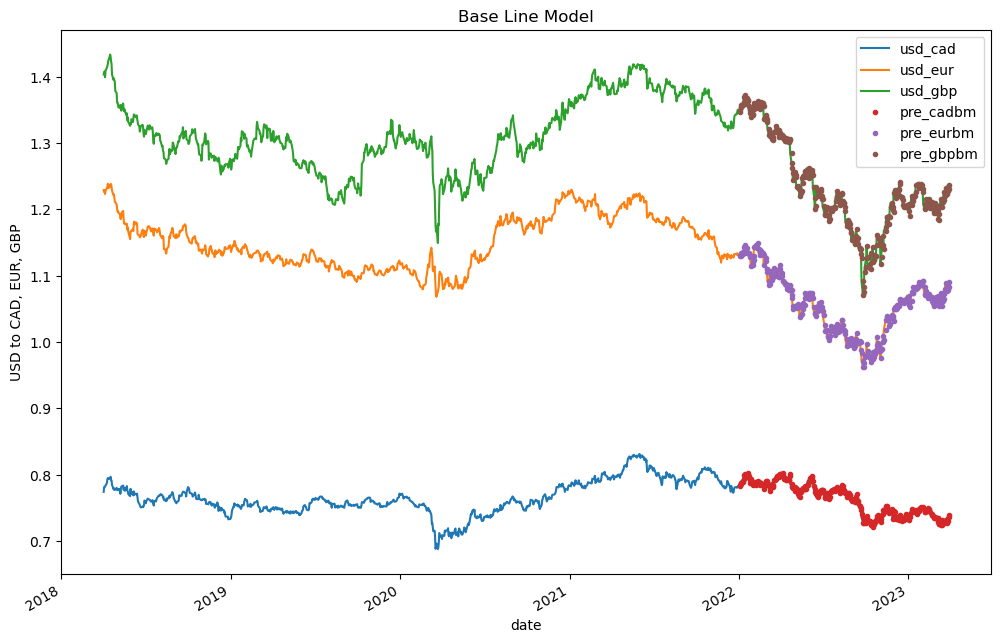

In [97]:
# Plot the baseline model

ax = df[['usd_cad', 'usd_eur', 'usd_gbp','pre_cadbm', 'pre_eurbm', 'pre_gbpbm']].plot(figsize=(12, 8), style=['-', '-', '-', '.', '.', '.'])

plt.title('Base Line Model')
plt.ylabel('USD to CAD, EUR, GBP')
plt.xlabel('date')
plt.show()

In [74]:
# R2 score for base line model

print('the R2 of cad is:', r2_score(y_test_cad, predicted_prices_cad))
print('the R2 of eur is:',r2_score(y_test_eur, predicted_prices_eur))
print('the R2 of gbp is:',r2_score(y_test_gbp, predicted_prices_gbp))
print('the MSE of cad is:', mean_squared_error(y_test_cad, predicted_prices_cad))
print('the RMSE of cad is:', np.sqrt(mean_squared_error(y_test_cad, predicted_prices_cad)))

print('the MSE of eur is:', mean_squared_error(y_test_cad, predicted_prices_eur))
print('the RMSE of eur is:', np.sqrt(mean_squared_error(y_test_cad, predicted_prices_eur)))

print('the MSE of gbp is:', mean_squared_error(y_test_cad, predicted_prices_gbp))
print('the RMSE of gbp is:', np.sqrt(mean_squared_error(y_test_cad, predicted_prices_gbp)))

the R2 of cad is: 0.9750307713908158
the R2 of eur is: 0.9796218062956314
the R2 of gbp is: 0.9831046758052981
the MSE of cad is: 1.4242226711016082e-05
the RMSE of cad is: 0.0037738874799092886
the MSE of eur is: 0.08812137161016889
the RMSE of eur is: 0.29685244080210776
the MSE of gbp is: 0.2237550122652172
the RMSE of gbp is: 0.47302749630990504


Baseline model work very well for one day ahead prediction with R-squared close to 1 and very small MSE and RMSE.

# Model using Random Forest

In [10]:
# Define different random forest regressors models for each currency
RF_model_cad = RandomForestRegressor(n_estimators=5000, random_state=42)
RF_model_eur = RandomForestRegressor(n_estimators=5000, random_state=42)
RF_model_gbp = RandomForestRegressor(n_estimators=5000, random_state=42)

In [11]:
# Determining number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=1000, stop=5000, num=10)]
# number of features at every split
max_features = ['auto', 'sqrt']
# max depth
max_depth = [int(x) for x in np.linspace(10, 100, num=10)]
max_depth.append(None)
# create random grid
random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth}
# Random search of parameters with 3 fold cross validation
rf_random_cad = RandomizedSearchCV(estimator=RF_model_cad, param_distributions=random_grid,
                                n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random_eur = RandomizedSearchCV(estimator=RF_model_eur, param_distributions=random_grid,
                                n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random_gbp = RandomizedSearchCV(estimator=RF_model_gbp, param_distributions=random_grid,
                                n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
# Fit the model
rf_random_cad.fit(X_train, y_train_cad)
rf_random_eur.fit(X_train, y_train_eur)
rf_random_gbp.fit(X_train, y_train_gbp)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END .max_depth=70, max_features=sqrt, n_estimators=1888; total time=   7.4s
[CV] END .max_depth=70, max_features=sqrt, n_estimators=1888; total time=   8.0s
[CV] END .max_depth=70, max_features=sqrt, n_estimators=1888; total time=   8.0s
[CV] END .max_depth=50, max_features=sqrt, n_estimators=2333; total time=   9.4s
[CV] END .max_depth=50, max_features=sqrt, n_estimators=2333; total time=   9.5s
[CV] END .max_depth=50, max_features=sqrt, n_estimators=2333; total time=   9.9s
[CV] END .max_depth=10, max_features=sqrt, n_estimators=3222; total time=  11.2s
[CV] END .max_depth=10, max_features=sqrt, n_estimators=3222; total time=  11.8s
[CV] END .max_depth=10, max_features=sqrt, n_estimators=3222; total time=  12.4s
[CV] END max_depth=100, max_features=auto, n_estimators=1000; total time=  33.4s
[CV] END max_depth=100, max_features=auto, n_estimators=1000; total time=  33.5s
[CV] END .max_depth=60, max_features=sqrt, n_e

/Users/sukem09/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .max_depth=10, max_features=auto, n_estimators=5000; total time= 2.8min
[CV] END .max_depth=40, max_features=auto, n_estimators=4111; total time= 2.5min
[CV] END .max_depth=40, max_features=auto, n_estimators=4111; total time= 2.6min
[CV] END .max_depth=10, max_features=auto, n_estimators=5000; total time= 2.9min
[CV] END .max_depth=10, max_features=auto, n_estimators=5000; total time= 2.9min
[CV] END .max_depth=50, max_features=sqrt, n_estimators=3666; total time=  15.6s
[CV] END .max_depth=40, max_features=auto, n_estimators=4111; total time= 2.6min
[CV] END .max_depth=50, max_features=sqrt, n_estimators=3666; total time=  15.5s
[CV] END .max_depth=50, max_features=sqrt, n_estimators=3666; total time=  16.1s
[CV] END max_depth=None, max_features=sqrt, n_estimators=1000; total time=   4.5s
[CV] END max_depth=None, max_features=sqrt, n_estimators=1000; total time=   4.2s
[CV] END max_depth=None, max_features=sqrt, n_estimators=1000; total time=   4.3s
[CV] END .max_depth=40, m

/Users/sukem09/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .max_depth=10, max_features=sqrt, n_estimators=4555; total time=  18.8s
[CV] END .max_depth=10, max_features=sqrt, n_estimators=4555; total time=  18.7s
[CV] END max_depth=100, max_features=sqrt, n_estimators=4111; total time=  18.5s
[CV] END .max_depth=40, max_features=auto, n_estimators=4111; total time= 2.5min
[CV] END max_depth=100, max_features=sqrt, n_estimators=4111; total time=  18.7s
[CV] END max_depth=100, max_features=sqrt, n_estimators=4111; total time=  19.9s
[CV] END .max_depth=10, max_features=auto, n_estimators=5000; total time= 2.8min
[CV] END .max_depth=10, max_features=auto, n_estimators=5000; total time= 2.9min
[CV] END .max_depth=40, max_features=auto, n_estimators=4111; total time= 2.6min
[CV] END .max_depth=10, max_features=auto, n_estimators=5000; total time= 3.0min
[CV] END .max_depth=50, max_features=sqrt, n_estimators=3666; total time=  16.7s
[CV] END .max_depth=40, max_features=auto, n_estimators=4111; total time= 2.8min
[CV] END .max_depth=50, max_

RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_estimators=5000,
                                                   random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [1000, 1444, 1888, 2333,
                                                         2777, 3222, 3666, 4111,
                                                         4555, 5000]},
                   random_state=42, verbose=2)

In [94]:
# Best hyperparameters for each currency
print(rf_random_cad.best_params_)
print(rf_random_eur.best_params_)
print(rf_random_gbp.best_params_)
print(rf_random_cad.best_estimator_)
print(rf_random_eur.best_estimator_)
print(rf_random_gbp.best_estimator_)


{'n_estimators': 5000, 'max_features': 'auto', 'max_depth': 10}
{'n_estimators': 3666, 'max_features': 'auto', 'max_depth': 20}
{'n_estimators': 2777, 'max_features': 'auto', 'max_depth': 20}
RandomForestRegressor(max_depth=10, n_estimators=5000, random_state=42)
RandomForestRegressor(max_depth=20, n_estimators=3666, random_state=42)
RandomForestRegressor(max_depth=20, n_estimators=2777, random_state=42)


In [13]:
# Make predictions using the best parameters
predictions_cad = rf_random_cad.best_estimator_.predict(X_test)
predictions_eur = rf_random_eur.best_estimator_.predict(X_test)
predictions_gbp = rf_random_gbp.best_estimator_.predict(X_test)


test['pre_cadrf1'], test['pre_eurf1'], test['pre_gbprf1'] = predictions_cad, predictions_eur, predictions_gbp
df = df.merge(test[['pre_cadrf1', 'pre_eurf1', 'pre_gbprf1']], how='left', left_index=True, right_index=True)

/var/folders/mq/f0db6b294kj_3n5gcz2cyqlh0000gn/T/ipykernel_17587/1177045637.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pre_cadrf1'], test['pre_eurf1'], test['pre_gbprf1'] = predictions_cad, predictions_eur, predictions_gbp
/var/folders/mq/f0db6b294kj_3n5gcz2cyqlh0000gn/T/ipykernel_17587/1177045637.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pre_cadrf1'], test['pre_eurf1'], test['pre_gbprf1'] = predictions_cad, predictions_eur, predictions_gbp
/var/folders/mq/f0db6b294kj_3n5gcz2c

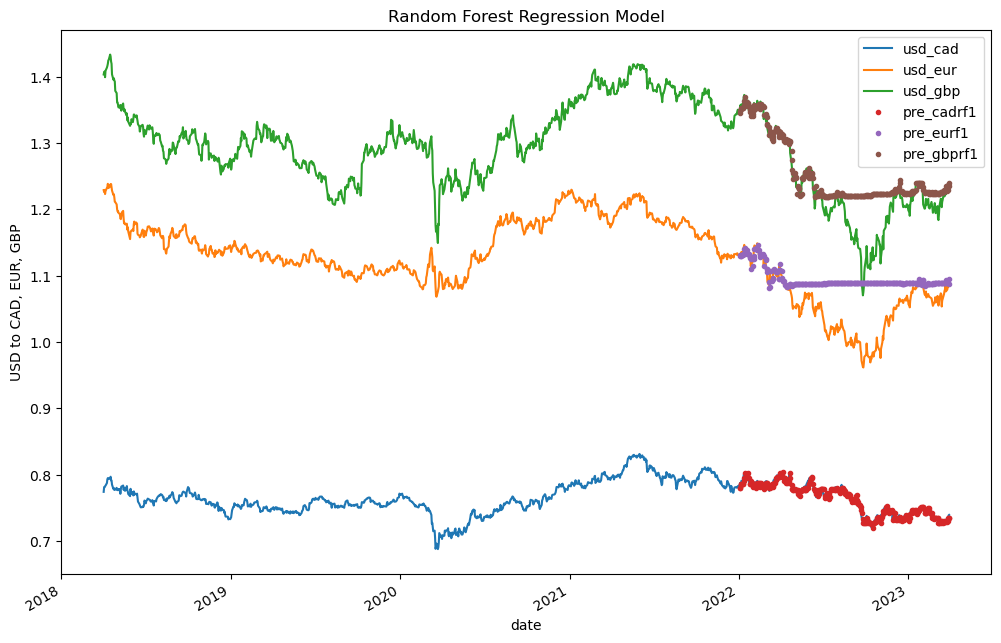

In [98]:
#Plot the results

ax = df[['usd_cad', 'usd_eur', 'usd_gbp', 'pre_cadrf1', 'pre_eurf1', 'pre_gbprf1']].plot(figsize=(12, 8), style=['-', '-', '-', '.', '.', '.'])

plt.title('Random Forest Regression Model')
plt.ylabel('USD to CAD, EUR, GBP')
plt.xlabel('date')
plt.show()

In [15]:
# Results of  R2 score and MSE and RMSE
print('the model of cad score is:', rf_random_cad.score(X_test, y_test_cad))
print('the model of Eur score is:', rf_random_eur.score(X_test, y_test_eur))
print('the model of Gbp score is:', rf_random_gbp.score(X_test, y_test_gbp))

print('the MSE of cad is:', mean_squared_error(y_test_cad, predictions_cad))
print('the RMSE of cad is:', np.sqrt(mean_squared_error(y_test_cad, predictions_cad)))

print('the MSE of eur is:', mean_squared_error(y_test_eur, predictions_eur))
print('the RMSE of eur is:', np.sqrt(mean_squared_error(y_test_eur, predictions_eur)))

print('the MSE of gbp is:', mean_squared_error(y_test_gbp, predictions_gbp))
print('the RMSE of gbp is:', np.sqrt(mean_squared_error(y_test_gbp, predictions_gbp)))


the model of cad score is: 0.97051852560321
the model of Eur score is: -0.3406085240396386
the model of Gbp score is: 0.6825534239627584
the MSE of cad is: 1.6815971718872356e-05
the RMSE of cad is: 0.004100728193732469
the MSE of eur is: 0.0027660788230942914
the RMSE of eur is: 0.05259352453576668
the MSE of gbp is: 0.001493142303575886
the RMSE of gbp is: 0.038641199561813375


For Model Score (R-squared):
The model for CAD has a high R-squared score of approximately 0.9705, indicating a strong fit.
The model for EUR has a negative score of approximately -0.3406, suggesting poor model performance.
The model for GBP has a moderate R-squared score of approximately 0.6822, indicating a reasonable fit.

For Mean Squared Error (MSE)
The MSE for CAD is extremely small (close to zero), indicating very accurate predictions.
The MSE for EUR is relatively higher, suggesting larger prediction errors.
The MSE for GBP is moderate, indicating a reasonable level of prediction accuracy.

For the Root Mean Squared Error (RMSE)
The RMSE for CAD is very low (approximately 0.0041), indicating high prediction accuracy with small errors.
The RMSE for EUR is relatively high (approximately 0.0526), suggesting larger prediction errors.
The RMSE for GBP is moderate (approximately 0.0386), indicating a reasonable level of prediction accuracy with moderate errors.

In [99]:
# Checking overfitting by plotting the training and testing scores
# Make predictions on traing data using the best parameters
predictions_cad = rf_random_cad.best_estimator_.predict(X_train)
predictions_eur = rf_random_eur.best_estimator_.predict(X_train)
predictions_gbp = rf_random_gbp.best_estimator_.predict(X_train)

# Calculate the R2 and MSE for training data
print('the model of cad score is:', rf_random_cad.score(X_train, y_train_cad))
print('the model of Eur score is:', rf_random_eur.score(X_train, y_train_eur))
print('the model of Gbp score is:', rf_random_gbp.score(X_train, y_train_gbp))

print('the MSE of cad is:', mean_squared_error(y_train_cad, predictions_cad))
print('the RMSE of cad is:', np.sqrt(mean_squared_error(y_train_cad, predictions_cad)))

print('the MSE of eur is:', mean_squared_error(y_train_eur, predictions_eur))
print('the RMSE of eur is:', np.sqrt(mean_squared_error(y_train_eur, predictions_eur)))

print('the MSE of gbp is:', mean_squared_error(y_train_gbp, predictions_gbp))
print('the RMSE of gbp is:', np.sqrt(mean_squared_error(y_train_gbp, predictions_gbp)))



the model of cad score is: 0.9972842040203024
the model of Eur score is: 0.9981976191083408
the model of Gbp score is: 0.9975418197829432
the MSE of cad is: 1.7645584958678817e-06
the RMSE of cad is: 0.00132836685289414
the MSE of eur is: 2.7649890973440423e-06
the RMSE of eur is: 0.0016628256364826838
the MSE of gbp is: 7.026584547905714e-06
the RMSE of gbp is: 0.002650770557386232


In [3]:
# The most important factor affect each model
# Create a DataFrame of feature importances
feature_importances_cadrf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_random_cad.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

feature_importances_eurrf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_random_eur.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

feature_importances_gbprf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_random_gbp.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)


In [76]:
feature_importances_cadrf.head(10)

,feature,importance
0,usd_cad_lag1d,0.909368
1,usd_cad_lag2d,0.061012
2,usd_cad_lag3d,0.005733
3,ftse100_lag3d,0.001686
4,ftse100_lag4d,0.001185
5,ftse100_lag5d,0.001094
6,stoxx600_lag2d,0.000982
7,ftse100_lag2d,0.000942
8,ftse100_lag1d,0.000834
9,usd_cad_lag5d,0.000719


In [77]:
feature_importances_eurrf.head(10)

,feature,importance
0,usd_eur_lag1d,0.986138
1,usd_eur_lag2d,0.001733
2,usd_eur_lag3d,0.000269
3,usd_cad_lag1d,0.000258
4,ftse100_lag2d,0.000257
5,ftse100_lag1d,0.000242
6,usd_eur_lag4d,0.000242
7,usd_eur_lag5d,0.000239
8,sptsx_lag4d,0.000230
9,usd_eur_lag9d,0.000220


In [78]:

feature_importances_gbprf.head(10)

,feature,importance
0,usd_gbp_lag1d,0.975961
1,usd_gbp_lag2d,0.002506
2,usd_gbp_lag10d,0.001797
3,stoxx600_lag2d,0.000991
4,ftse100_lag2d,0.000800
5,usd_gbp_lag3d,0.000599
6,usd_gbp_lag9d,0.000543
7,usd_cad_lag1d,0.000492
8,sptsx_lag1d,0.000477
9,usd_eur_lag5d,0.000457


# XGboost model

In [20]:
# Hyperparameter tuning for XGBoost
# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=2000, stop=10000, num=5)],
    'max_depth': [int(x) for x in np.linspace(1, 10, num=1)],
    'learning_rate': [0.01, 0.05, 0.2, 0.4],
}


In [21]:
# Create XGBRegressor objects for each currency
reg_cad = xgb.XGBRegressor(n_estimators=10000)
reg_eur = xgb.XGBRegressor(n_estimators=10000)
reg_gbp = xgb.XGBRegressor(n_estimators=10000)

# Create RandomizedSearchCV objects for each model to choose the best parameters
reg_cad = RandomizedSearchCV(reg_cad, param_distributions=gbm_param_grid, n_iter=100, scoring='r2', n_jobs=-1, cv=3, verbose=3)
reg_eur = RandomizedSearchCV(reg_eur, param_distributions=gbm_param_grid, n_iter=100, scoring='r2', n_jobs=-1, cv=3, verbose=3)
reg_gbp = RandomizedSearchCV(reg_gbp, param_distributions=gbm_param_grid, n_iter=100, scoring='r2', n_jobs=-1, cv=3, verbose=3)

reg_cad.fit(X_train, y_train_cad)
reg_eur.fit(X_train, y_train_eur)
reg_gbp.fit(X_train, y_train_gbp)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/sukem09/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 3/3] END learning_rate=0.01, max_depth=1, n_estimators=2000;, score=-0.152 total time=   5.6s
[CV 2/3] END learning_rate=0.01, max_depth=1, n_estimators=2000;, score=0.465 total time=   5.6s
[CV 1/3] END learning_rate=0.01, max_depth=1, n_estimators=2000;, score=0.841 total time=   5.7s
[CV 3/3] END learning_rate=0.01, max_depth=1, n_estimators=4000;, score=-0.192 total time=  11.1s
[CV 1/3] END learning_rate=0.01, max_depth=1, n_estimators=4000;, score=0.847 total time=  11.3s
[CV 2/3] END learning_rate=0.01, max_depth=1, n_estimators=4000;, score=0.381 total time=  11.6s
[CV 1/3] END learning_rate=0.01, max_depth=1, n_estimators=6000;, score=0.853 total time=  16.2s
[CV 2/3] END learning_rate=0.01, max_depth=1, n_estimators=6000;, score=0.352 total time=  17.2s
[CV 3/3] END learning_rate=0.01, max_depth=1, n_estimators=6000;, score=-0.267 total time=  17.1s
[CV 1/3] END learning_rate=0.05, max_depth=1, n_estimators=2000;, score=0.853 total time=   5.9s
[CV 2/3] END learning_rate=

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_delta_step=None, max_depth=None,
                            

In [89]:
# print results
print(reg_cad.best_params_)
print(reg_eur.best_params_)
print(reg_gbp.best_params_)
print(reg_cad.best_estimator_) # best estimator for the model
print(reg_eur.best_estimator_)
print(reg_gbp.best_estimator_)

{'n_estimators': 2000, 'max_depth': 1, 'learning_rate': 0.01}
{'n_estimators': 4000, 'max_depth': 1, 'learning_rate': 0.05}
{'n_estimators': 2000, 'max_depth': 1, 'learning_rate': 0.01}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             co

In [22]:
# Prediction on the test set
predictionxg_cad = reg_cad.predict(X_test)
predictionxg_eur = reg_eur.predict(X_test)
predictionxg_gbp = reg_gbp.predict(X_test)

# Save the predictions
test['pre_cadxg'], test['pre_eurxg'], test['pre_gbpxg'] = predictionxg_cad, predictionxg_eur, predictionxg_gbp
df = df.merge(test[['pre_cadxg', 'pre_eurxg', 'pre_gbpxg']], how='left', left_index=True, right_index=True)

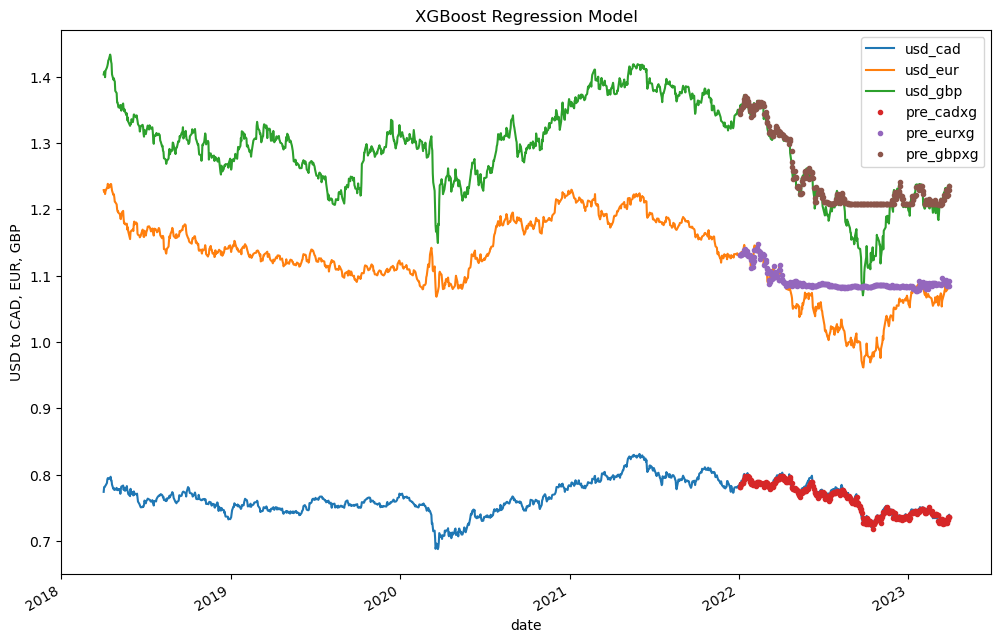

In [23]:
ax = df[['usd_cad', 'usd_eur', 'usd_gbp', 'pre_cadxg', 'pre_eurxg', 'pre_gbpxg']].plot(figsize=(12, 8), style=['-', '-', '-', '.', '.', '.'])

plt.title('XGBoost Regression Model')
plt.ylabel('USD to CAD, EUR, GBP')
plt.xlabel('date')
plt.show()

In [79]:
# The most important factor affect each model
# Create a DataFrame of feature importances
feature_importances_cadxg = pd.DataFrame({
    'feature': X_train.columns,
    'importance': reg_cad.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

feature_importances_eurxg = pd.DataFrame({
    'feature': X_train.columns,
    'importance': reg_eur.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

feature_importances_gbpxg = pd.DataFrame({
    'feature': X_train.columns,
    'importance': reg_gbp.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

In [80]:
feature_importances_cadxg.head(10)

,feature,importance
0,uncertainty_uk_lag1m,0.238558
1,usd_cad_lag1d,0.214282
2,usd_cad_lag5d,0.153982
3,usd_cad_lag6d,0.080628
4,usd_cad_lag3d,0.062485
5,usd_cad_lag2d,0.053576
6,usd_gbp_lag7d,0.040742
7,sp500_lag1d,0.028780
8,cpi_us_lag2m,0.024374
9,usd_gbp_lag4d,0.024099


In [81]:
feature_importances_eurxg.head(10)

,feature,importance
0,usd_eur_lag1d,0.722521
1,unrate_uk_lag1m,0.117521
2,unrate_eu_lag1m,0.056904
3,unrate_us_lag2m,0.013577
4,unrate_eu_lag3m,0.012410
5,usd_eur_lag6d,0.012121
6,usd_eur_lag2d,0.007721
7,usd_eur_lag3d,0.007716
8,unrate_ca_lag3m,0.007266
9,usd_eur_lag10d,0.006446


In [82]:
feature_importances_gbpxg.head(10)

,feature,importance
0,usd_gbp_lag4d,0.349414
1,usd_gbp_lag7d,0.147877
2,usd_gbp_lag1d,0.134655
3,usd_cad_lag5d,0.129261
4,usd_gbp_lag2d,0.063136
5,usd_cad_lag2d,0.040590
6,usd_cad_lag4d,0.022600
7,usd_cad_lag8d,0.022449
8,usd_gbp_lag10d,0.019945
9,usd_cad_lag1d,0.013713


In [87]:
# Results of  R2 score and MSE and RMSE
print('the R2 of cad is:', r2_score(y_test_cad, predictionxg_cad))
print('the R2 of eur is:',r2_score(y_test_eur, predictionxg_eur))
print('the R2 of gbp is:',r2_score(y_test_gbp, predictionxg_gbp))

print('the MSE of cad is:', mean_squared_error(y_test_cad, predictionxg_cad))
print('the RMSE of cad is:', np.sqrt(mean_squared_error(y_test_cad, predictionxg_cad)))

print('the MSE of eur is:', mean_squared_error(y_test_cad, predictionxg_eur))
print('the RMSE of eur is:', np.sqrt(mean_squared_error(y_test_cad, predictionxg_eur)))

print('the MSE of gbp is:', mean_squared_error(y_test_cad, predictionxg_gbp))
print('the RMSE of gbp is:', np.sqrt(mean_squared_error(y_test_cad, predictionxg_gbp)))

the R2 of cad is: 0.9641572350850856
the R2 of eur is: -0.20346504263930942
the R2 of gbp is: 0.7795793869423525
the MSE of cad is: 2.044439545401489e-05
the RMSE of cad is: 0.004521547904646692
the MSE of eur is: 0.10873450818713337
the RMSE of eur is: 0.3297491594942031
the MSE of gbp is: 0.23640173408657944
the RMSE of gbp is: 0.48621161451221984


In [100]:
# Prediction on the traning set to check overfitting
predictionxg_cad = reg_cad.predict(X_train)
predictionxg_eur = reg_eur.predict(X_train)
predictionxg_gbp = reg_gbp.predict(X_train)

# Print R2 and MSE for training data

print('the R2 of cad is:', r2_score(y_train_cad, predictionxg_cad))
print('the R2 of eur is:',r2_score(y_train_eur, predictionxg_eur))
print('the R2 of gbp is:',r2_score(y_train_gbp, predictionxg_gbp))

print('the MSE of cad is:', mean_squared_error(y_train_cad, predictionxg_cad))
print('the RMSE of cad is:', np.sqrt(mean_squared_error(y_train_cad, predictionxg_cad)))

print('the MSE of eur is:', mean_squared_error(y_train_eur, predictionxg_eur))
print('the RMSE of eur is:', np.sqrt(mean_squared_error(y_train_eur, predictionxg_eur)))

print('the MSE of gbp is:', mean_squared_error(y_train_gbp, predictionxg_gbp))
print('the RMSE of gbp is:', np.sqrt(mean_squared_error(y_train_gbp, predictionxg_gbp)))

the R2 of cad is: 0.98979564922062
the R2 of eur is: 0.9952467098748404
the R2 of gbp is: 0.9883702984877173
the MSE of cad is: 6.63016441484527e-06
the RMSE of cad is: 0.002574910564436223
the MSE of eur is: 7.2919078499998025e-06
the RMSE of eur is: 0.002700353282442837
the MSE of gbp is: 3.3242917006631495e-05
the RMSE of gbp is: 0.005765667091207356


# Long-Short Term Memory model

In [38]:
# Split the traing data into train and validation sets
X_train_lstm, X_val_lstm, y_train_cadlstm, y_val_cadlstm = train_test_split(X_train, y_train_cad, test_size=0.33, random_state=42)
X_train_lstm, X_val_lstm, y_train_eurlstm, y_val_eurlstm = train_test_split(X_train, y_train_eur, test_size=0.33, random_state=42)
X_train_lstm, X_val_lstm, y_train_gbplstm, y_val_gbplstm = train_test_split(X_train, y_train_gbp, test_size=0.33, random_state=42)


In [39]:
import numpy as np

# Convert DataFrame to NumPy array
X_train_lstm = X_train_lstm.to_numpy()

# Reshape X_train_array
X_train_reshaped = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)

# Define your LSTM model using Keras
def build_lstm_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))  # LSTM layer
    model.add(keras.layers.Dense(1, activation='linear'))  
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=0.001, max_value=0.01, sampling='log')),
                  loss='mean_squared_error')
    return model

tuner_cad = RandomSearch( build_lstm_model, objective='val_loss', max_trials=50, directory='my_dir_cad', project_name='my_lstm_tuning_cad')
tuner_eur = RandomSearch( build_lstm_model, objective='val_loss', max_trials=50, directory='my_dir_eur', project_name='my_lstm_tuning_eur')
tuner_gbp = RandomSearch( build_lstm_model, objective='val_loss', max_trials=50, directory='my_dir_gbp', project_name='my_lstm_tuning_gbp')
# Perform the hyperparameter search for each target variable
tuner_cad.search(X_train_reshaped, y_train_cadlstm, epochs=30, validation_data=(X_val_lstm, y_val_cadlstm), batch_size=64)
tuner_eur.search(X_train_reshaped, y_train_eurlstm, epochs=30, validation_data=(X_val_lstm, y_val_eurlstm), batch_size=64)
tuner_gbp.search(X_train_reshaped, y_train_gbplstm, epochs=30, validation_data=(X_val_lstm, y_val_gbplstm), batch_size=64)

Trial 10 Complete [00h 00m 44s]
val_loss: 0.0008920447435230017

Best val_loss So Far: 0.0005973061197437346
Total elapsed time: 00h 25m 26s
INFO:tensorflow:Oracle triggered exit


In [40]:

# Get the best hyperparameters and build the final model for each target variable
best_hps_cad = tuner_cad.get_best_hyperparameters(num_trials=1)[0]
best_hps_eur = tuner_eur.get_best_hyperparameters(num_trials=1)[0]
best_hps_gbp = tuner_gbp.get_best_hyperparameters(num_trials=1)[0]

best_model_cad = build_lstm_model(best_hps_cad)
best_model_eur = build_lstm_model(best_hps_eur)
best_model_gbp = build_lstm_model(best_hps_gbp)

#Train the final model with the best hyperparameters
best_model_cad.fit(X_train, y_train_cad, epochs=50, batch_size=64)
best_model_eur.fit(X_train, y_train_eur, epochs=50, batch_size=64)
best_model_gbp.fit(X_train, y_train_gbp, epochs=50, batch_size=64)

Epoch 1/50
16/16 [==============================] - 6s 240ms/step - loss: 0.0602
Epoch 2/50
16/16 [==============================] - 4s 277ms/step - loss: 3.4973e-04
Epoch 3/50
16/16 [==============================] - 4s 251ms/step - loss: 2.3687e-04
Epoch 4/50
16/16 [==============================] - 4s 246ms/step - loss: 2.2968e-04
Epoch 5/50
16/16 [==============================] - 5s 292ms/step - loss: 2.4148e-04
Epoch 6/50
16/16 [==============================] - 4s 276ms/step - loss: 4.0842e-04
Epoch 7/50
16/16 [==============================] - 4s 280ms/step - loss: 2.6019e-04
Epoch 8/50
16/16 [==============================] - 4s 257ms/step - loss: 2.4906e-04
Epoch 9/50
16/16 [==============================] - 6s 345ms/step - loss: 2.8283e-04
Epoch 10/50
16/16 [==============================] - 4s 262ms/step - loss: 2.7407e-04
Epoch 11/50
16/16 [==============================] - 4s 240ms/step - loss: 2.5469e-04
Epoch 12/50
16/16 [==============================] - 4s 244ms/step 

In [93]:
# Print the optimal hyperparameters
print(f"""For LSTM model of exchange rate USD per CAD: The optimal number of units in the first LSTM layer is {best_hps_cad.get('units')} 
and the optimal learning rate for the optimizer is {best_hps_cad.get('learning_rate')}.
""")
print(f"""For LSTM model of exchange rate USD per EUR: The optimal number of units in the first LSTM layer is {best_hps_eur.get('units')} and the optimal learning rate for the optimizer
is {best_hps_eur.get('learning_rate')}.
""")
print(f"""For LSTM model of exchange rate USD per GBP: The optimal number of units in the first LSTM layer is {best_hps_gbp.get('units')} and the optimal learning rate for the optimizer
is {best_hps_gbp.get('learning_rate')}.
""")


For LSTM model of exchange rate USD per CAD: The optimal number of units in the first LSTM layer is 192 
and the optimal learning rate for the optimizer is 0.005063713408586714.

For LSTM model of exchange rate USD per EUR: The optimal number of units in the first LSTM layer is 480 and the optimal learning rate for the optimizer
is 0.0012281783364939784.

For LSTM model of exchange rate USD per GBP: The optimal number of units in the first LSTM layer is 384 and the optimal learning rate for the optimizer
is 0.004325833653269832.



In [41]:
# Use the model to make predictions on the test set
lstm_predictions_cad = best_model_cad.predict(X_test)
lstm_predictions_eur = best_model_eur.predict(X_test)
lstm_predictions_gbp = best_model_gbp.predict(X_test)

test['pre_cadls'], test['pre_eurls'], test['pre_gbpls'] = lstm_predictions_cad, lstm_predictions_eur, lstm_predictions_gbp
df = df.merge(test[['pre_cadls', 'pre_eurls', 'pre_gbpls']], how='left', left_index=True, right_index=True)

10/10 [==============================] - 2s 140ms/step


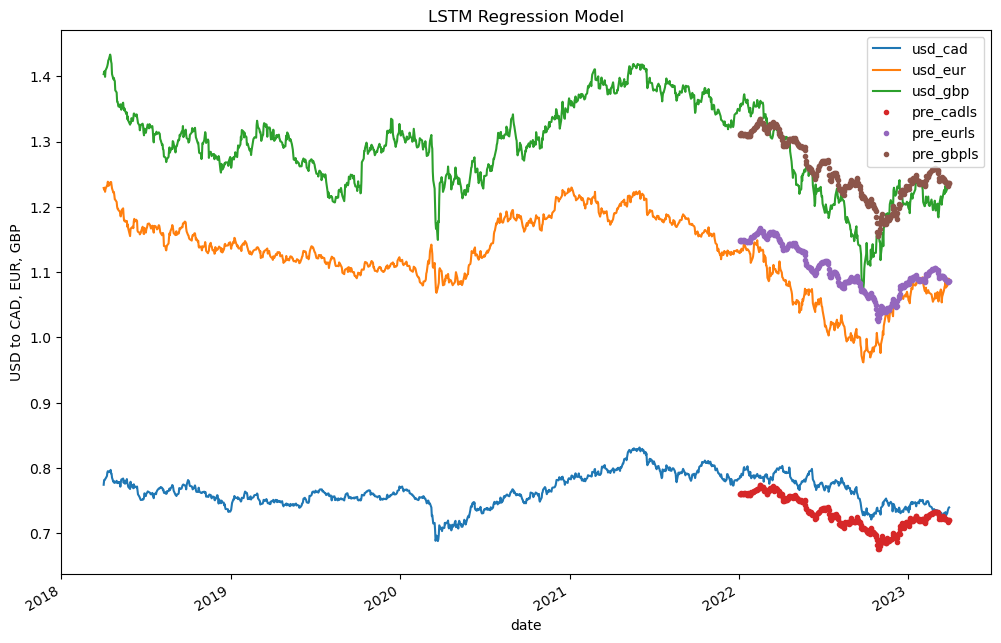

In [44]:
# Plot the results
ax = df[['usd_cad', 'usd_eur', 'usd_gbp', 'pre_cadls', 'pre_eurls', 'pre_gbpls']].plot(figsize=(12, 8), style=['-', '-', '-', '.', '.', '.'])

plt.title('LSTM Regression Model')
plt.ylabel('USD to CAD, EUR, GBP')
plt.xlabel('date')
plt.show()

In [88]:
# Results of  R2 score and MSE and RMSE

print(r2_score(y_test_cad, lstm_predictions_cad))
print(r2_score(y_test_eur, lstm_predictions_eur))
print(r2_score(y_test_gbp, lstm_predictions_gbp))

print('the MSE of cad is:', mean_squared_error(y_test_cad, lstm_predictions_cad))
print('the RMSE of cad is:', np.sqrt(mean_squared_error(y_test_cad, lstm_predictions_cad)))

print('the MSE of eur is:', mean_squared_error(y_test_cad, lstm_predictions_eur))
print('the RMSE of eur is:', np.sqrt(mean_squared_error(y_test_cad, lstm_predictions_eur)))

print('the MSE of gbp is:', mean_squared_error(y_test_cad, lstm_predictions_gbp))
print('the RMSE of gbp is:', np.sqrt(mean_squared_error(y_test_cad, lstm_predictions_gbp)))

-1.3864030105356324
-0.5035408962330559
0.5529629576826542
the MSE of cad is: 0.0013611831279160304
the RMSE of cad is: 0.0368942153720069
the MSE of eur is: 0.11654492904481915
the RMSE of eur is: 0.3413867733888048
the MSE of gbp is: 0.24362840341618544
the RMSE of gbp is: 0.4935872804440826


In [101]:
# Predictions on the training set to check overfitting

lstm_predictions_cad = best_model_cad.predict(X_train)
lstm_predictions_eur = best_model_eur.predict(X_train)
lstm_predictions_gbp = best_model_gbp.predict(X_train)

# Print R2 and MSE for training data

print(r2_score(y_train_cad, lstm_predictions_cad))
print(r2_score(y_train_eur, lstm_predictions_eur))
print(r2_score(y_train_gbp, lstm_predictions_gbp))

print('the MSE of cad is:', mean_squared_error(y_train_cad, lstm_predictions_cad))
print('the RMSE of cad is:', np.sqrt(mean_squared_error(y_train_cad, lstm_predictions_cad)))


print('the MSE of eur is:', mean_squared_error(y_train_eur, lstm_predictions_eur))
print('the RMSE of eur is:', np.sqrt(mean_squared_error(y_train_eur, lstm_predictions_eur)))

print('the MSE of gbp is:', mean_squared_error(y_train_gbp, lstm_predictions_gbp))
print('the RMSE of gbp is:', np.sqrt(mean_squared_error(y_train_gbp, lstm_predictions_gbp)))


30/30 [==============================] - 3s 95ms/step
0.6269692121184636
0.5809598384713103
0.698534403390847
the MSE of cad is: 0.00024237264172176224
the RMSE of cad is: 0.015568321737482247
the MSE of eur is: 0.0006428394149859904
the RMSE of eur is: 0.025354278041111532
the MSE of gbp is: 0.0008617242495732547
the RMSE of gbp is: 0.029355140087781128
